In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,AveragePooling2D,Conv2DTranspose, Input, Concatenate, Add, BatchNormalization, Activation, MultiHeadAttention
from ipywidgets import IntProgress
from IPython.display import display
import os
import cv2
import PIL
import PIL.Image
import json
import random
from random import randint as rand
from os import listdir
from os.path import isfile, join
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#парсинг coco датасета для обучения object detection
import tensorflow as tf
import json
from PIL import Image

path_to_images = "C:/users/user/ai tests/autoencoder tests/datasets/train2014"
path_to_json = "C:/users/user/ai tests/autoencoder tests/datasets/annotations/instances_train2014.json"

with open(path_to_json, 'r') as f:
    json_data = json.load(f)

image_boxes_dict = {str(annotation['image_id']): [] for annotation in json_data['annotations']}

for annotation in json_data['annotations']:
    image_boxes_dict[str(annotation['image_id'])].append(annotation['bbox'])
    
def preprocess_image(img_filename):
    img = tf.io.read_file(img_filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 128 - 1
    return img

#используется повторение рамок, количество рамок всегда одинаково при обучении
fixed_num_boxes = 50
def generator():
    for image_id, bounding_boxes in image_boxes_dict.items():
        image_path = path_to_images + f"/COCO_train2014_{image_id.rjust(12, '0')}.jpg"
        image = preprocess_image(image_path)
        level_x =  224 / image.shape[1]
        level_y =  224 / image.shape[0]
        image = tf.image.resize(image, (224, 224), method='area')
        rescaled_boxes = []
        while(len(rescaled_boxes) <  fixed_num_boxes):
            for box in bounding_boxes:
                rescaled_boxes.append([box[0] * level_x, box[1] * level_y, (box[2]+box[0]) * level_x, (box[3]+box[1]) * level_y])
                if len(rescaled_boxes) ==  fixed_num_boxes:
                    break
        yield image, rescaled_boxes

dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                                                        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)))
# для лучшего результата при обучении ставьте shuffle(10000) или более. Перемешивает долго. Использует много памяти. Обучение стабильнее.
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(100) 

In [ ]:
#отобразить одну картинку с рамками
for data in dataset.take(1):
    image, bounding_boxes = data
    print("Image Shape:", image.shape)
    image = image.numpy()
    for box in bounding_boxes:
        image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 1)
    plt.imshow((image+1)/2)
    plt.show()

In [76]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_layers_to_keep = 119
output_tensor = base_model.layers[num_layers_to_keep - 1].output
clipped_model = tf.keras.Model(inputs=base_model.input, outputs=output_tensor)
for layer in clipped_model.layers[:80]:
    layer.trainable = False

In [77]:
inputs = Input((224, 224 ,3))
x = clipped_model(inputs)
box_probabilities = Conv2D(2, kernel_size=1, activation = 'softmax')(x)
box_coords = Conv2D(4, kernel_size=1, activation = 'linear')(x)
outputs = [box_probabilities, box_coords]
RP_network = keras.Model(inputs, outputs)

In [11]:
RP_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 14, 14, 576)  616256      ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 2)    1154        ['model[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 4)    2308        ['model[0][0]']            

In [78]:
class RPNModel(keras.Model):
    def __init__(self, network):
        super().__init__()
        self.network = network
        self.lr = 1e-4
        self.optimizer = tf.keras.optimizers.Adam(self.lr)
        self.crossentropy = tf.keras.losses.CategoricalCrossentropy(reduction = 'none')
        self.hubert = tf.keras.losses.Huber(reduction = 'none')
    
    def draw_box(self, image, box, color = (255, 0, 0)):
        image = cv2.rectangle(image, 
                              (int(tf.clip_by_value(box[0], 0, 244)), int(tf.clip_by_value(box[1], 0, 244))), 
                              (int(tf.clip_by_value(box[2], 0, 244)), int(tf.clip_by_value(box[3], 0, 244))),
                              color, 1)
        return image
    
    #не используется, можете поэксперементировать с этим
    def draw_transparent_box(self, image, box, color):
        overlay = image.copy() 
        x, y, w, h = box
        x = int(tf.clip_by_value(x, 0, 244))
        y = int(tf.clip_by_value(y, 0, 244))
        w = int(tf.clip_by_value(w, 0, 244))
        h = int(tf.clip_by_value(h, 0, 244))
        
        cv2.rectangle(overlay, (x, y), (w, h), (100, 100, 100), -1)   
        color = 1 - color
        alpha = color/500
        image_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0) 
        return image_new
    
    def IoU(self, boxA, boxB):
        boxes = tf.concat([tf.expand_dims(boxA, axis = 0), tf.expand_dims(boxB, axis = 0)], axis = 0)
        A = tf.reduce_max(boxes, axis = 0)
        B = tf.reduce_min(boxes, axis = 0)
        xA = A[:, 0]
        yA = A[:, 1]
        xB = B[:, 2]
        yB = B[:, 3]

        interW = tf.nn.relu(xB - xA + 1)
        interH = tf.nn.relu(yB - yA + 1)

        interArea = interW * interH
        boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
        boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

        iou = interArea / tf.cast(boxAArea + boxBArea - interArea, dtype=tf.float32)
        return iou
    
    #На выходе всегда разное количество рамок, tf.function будет бесполезен
    def non_maximum_supression(self, boxes, scores, th = 0.6):
        num_boxes = boxes.shape[0]
        axis_A = tf.repeat(tf.expand_dims(boxes, axis = 0), num_boxes, axis = 0)
        axis_B = tf.tile(tf.expand_dims(boxes, axis=1), multiples=[1, num_boxes, 1])
        axis_A = tf.reshape(axis_A, [-1, 4])
        axis_B = tf.reshape(axis_B, [-1, 4])
        cross_iou = self.IoU(axis_A, axis_B)
        resulted_boxes = []
        resulted_scores = []
        for i in range(num_boxes):
            discard = False
            for j in range(num_boxes):
                if (cross_iou[i * num_boxes + j] > th):
                    if(scores[j, 1] > scores[i, 1]):
                        discard = True
                        break
            if not discard:
                resulted_boxes.append(boxes[i])
                resulted_scores.append(scores[i])
        resulted_boxes = tf.cast(resulted_boxes, dtype = tf.float32)
        resulted_scores = tf.cast(resulted_scores, dtype = tf.float32)
        return (resulted_boxes, resulted_scores)
    
    def testing(self, image = None, only_true = False, t = 0.5, top_k = None, nms = False):
        if image == None:
            for data in dataset.take(1):
                image, bounding_boxes = data
        
        image = tf.expand_dims(image, axis=0)
        result = self.network(image)
        image = (image+1)/2
        delta = 17.0
        shift = self.create_position_tensor(14)
        
        
        probabilities, coords = result
        coords += shift
        coords *= 17.0
        coords = tf.clip_by_value(coords, 0, 244)
        predicted_coords = tf.reshape(coords, [-1, 4])
        predicted_probs = tf.reshape(probabilities, [-1, 2])
        image = image[0].numpy()
        if nms:
            predicted_coords, predicted_probs = self.non_maximum_supression(predicted_coords, predicted_probs)
        top_boxes = []
        for i in range(predicted_coords.shape[0]):
            
            prob = float(predicted_probs[i, 1].numpy())
            if(top_k == None):
                if only_true == False or prob > t:
                    image = self.draw_box(image, predicted_coords[i], color = (prob, prob, prob))
            else:
                top_boxes.append([predicted_coords[i], prob])
        if (top_k != None):
            top_boxes = sorted(top_boxes, key=lambda box: box[1])
            for i in range(top_k):
                prob = top_boxes[-i - 1][1]
                image = self.draw_box(image, top_boxes[-i - 1][0], color = (prob, prob, prob))
                
        plt.imshow(image)

    def create_mask(self, n, s, at_beginning=True):
        if at_beginning:
            mask = tf.concat([tf.ones([n], dtype=tf.float32), tf.zeros([s - n], dtype=tf.float32)], axis=0)
        else:
            mask = tf.concat([tf.zeros([s - n], dtype=tf.float32), tf.ones([n], dtype=tf.float32)], axis=0)
        return mask

    def random_sample(self, length, num_ones):
        indices = tf.range(length)
        shuffled_indices = tf.random.shuffle(indices)
        return tf.cast((shuffled_indices<num_ones), dtype = tf.float32)
    
    def count_in_tensor(self, tensor, th, more = False):
        if more:
            true_positions = tf.cast(tensor > th, dtype = tf.float32)
        else:
            true_positions = tf.cast(tensor < th, dtype = tf.float32)
        return tf.reduce_sum(true_positions)

    def calculate_loss(self, pred_probs, pred_boxes, gt, minibatch_size = 64, alpha = 1, low_th = 0.3, high_th = 0.7):
        num_pred = pred_boxes.shape[0]
        num_gt = gt.shape[0]
        r_pred = tf.repeat(tf.expand_dims(pred_boxes, axis = 0), num_gt, axis = 0)
        r_gt = tf.tile(tf.expand_dims(gt, axis=1), multiples=[1, num_pred, 1])
        r_gt = tf.reshape(r_gt, shape=[-1, num_pred, 4])
        r_pred = tf.reshape(r_pred, [-1, 4])
        r_gt = tf.reshape(r_gt, [-1, 4])
        iou = self.IoU(r_pred, r_gt)
        iou = tf.reshape(iou, [num_gt, num_pred])
        max_iou_arg = tf.argmax(iou, axis = 0)
        corresponding_pred = pred_boxes
        corresponding_prob = pred_probs
        corresponding_gt = tf.gather(gt, max_iou_arg)
        iou_rates = tf.reduce_max(iou, axis = 0)
        indexes = tf.argsort(iou_rates, direction='ASCENDING')
        corresponding_pred = tf.gather(corresponding_pred, indexes)
        corresponding_prob = tf.gather(corresponding_prob, indexes)
        corresponding_gt = tf.gather(corresponding_gt, indexes)
        iou_rates = tf.gather(iou_rates, indexes)
        positive_true = tf.repeat(tf.expand_dims(tf.one_hot(1, 2), axis = 0), num_pred, axis = 0)
        negative_true = tf.repeat(tf.expand_dims(tf.one_hot(0, 2), axis = 0), num_pred, axis = 0)
        
        regression_loss = self.hubert(corresponding_pred, corresponding_gt)
        
        num_less_than_low_th = self.count_in_tensor(iou_rates, low_th, more = False)
        num_more_than_high_th = self.count_in_tensor(iou_rates, high_th, more = True)
        
        num_more_than_high_th = tf.maximum(num_more_than_high_th, minibatch_size//2)
        num_less_than_low_th = tf.maximum(num_less_than_low_th, minibatch_size//2)
        
        positive_sample_mask = tf.concat([tf.zeros([num_pred - num_more_than_high_th], dtype = tf.float32),
                                          self.random_sample(num_more_than_high_th, minibatch_size//2)], axis = 0)
        negative_sample_mask = tf.concat([self.random_sample(num_less_than_low_th, minibatch_size//2),
                                          tf.zeros([num_pred - num_less_than_low_th], dtype = tf.float32)], axis = 0)
        
        positive_loss = (self.crossentropy(positive_true, corresponding_prob) + regression_loss * alpha) * positive_sample_mask
        negative_loss = (self.crossentropy(negative_true, corresponding_prob)) * negative_sample_mask                          

        loss = tf.reduce_sum(negative_loss + positive_loss)

        return [loss, num_less_than_low_th, num_more_than_high_th]

    def create_position_tensor(self, n):
        x_positions = tf.linspace(0.0, float(n - 1), n)
        y_positions = tf.linspace(0.0, float(n - 1), n)
        x_grid, y_grid = tf.meshgrid(x_positions, y_positions)
        position_tensor = tf.stack([x_grid, y_grid, x_grid, y_grid], axis=-1)
        return position_tensor
    
    @tf.function
    def train_step(self, image, gt_boxes):
        image = tf.expand_dims(image, axis=0)
        delta = 16 #соотношение стороны карты признаков и исходной картинки
        shift = self.create_position_tensor(14)

        with tf.GradientTape() as tape:
            result = self.network(image)
            probabilities, coords = result
            #преобразование координат из относительных в абсолютные
            coords += shift
            coords *= 17.0
            #coords = tf.clip_by_value(coords, 0, 244) #проверьте, может так будет лучше
            predicted_coords = tf.reshape(coords, [-1, 4])
            predicted_probs = tf.reshape(probabilities, [-1, 2])
            loss, a, b = self.calculate_loss(predicted_probs, predicted_coords, gt_boxes, minibatch_size = 64)
            gradients = tape.gradient(loss, self.network.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.network.trainable_variables))

        return [tf.reduce_mean(loss), a, b]
        
model = RPNModel(RP_network)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


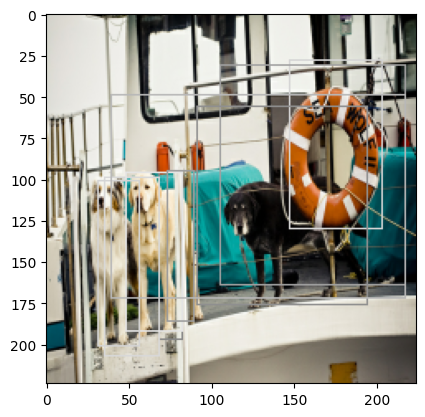

In [104]:
# only_true - использовать трешхолд рамок
# t - трешхолд
# nms - Non Maximum Supression
model.testing(only_true = True, t = 0.5, nms = True)

In [ ]:
for data in dataset.take(1):
    image, bounding_boxes = data
    print(model.train_step(image, bounding_boxes))

эпоха 1
ошибка: 273.2665100097656
tf.Tensor(32.0, shape=(), dtype=float32) tf.Tensor(86.0, shape=(), dtype=float32)


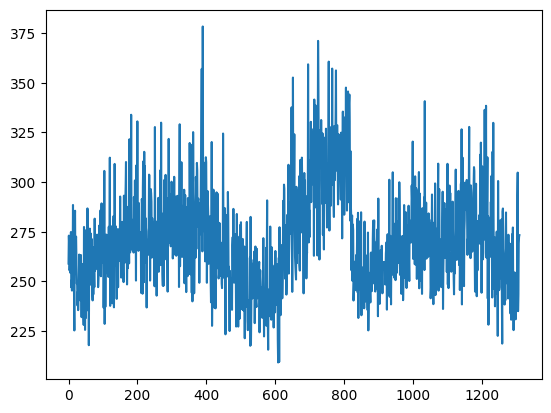

KeyboardInterrupt: 

In [72]:
#обучаем
epochs = 500
hist = np.array(np.empty([0]))
best_loss = 100000
from IPython.display import clear_output
for epoch in range(epochs):
    midloss = 0
    for step, x in enumerate(dataset):
        
        image, bounding_boxes = x
        loss, test1, test2 = model.train_step(image, bounding_boxes)
           
        midloss += loss
        if(step % 100 == 99):  
            clear_output(wait=True)
            print('эпоха ' + str(epoch))
            print('ошибка: ' + str(float(midloss/100)))
            print(test1, test2)
           
            hist = np.append(hist, float(midloss/100))
            plt.plot(np.arange(0,len(hist)), hist)
            plt.show()
            #сохранять лучший вариант
            if (midloss/100 < best_loss):
                best_loss = midloss/100
                model.network.save('best.h5')
                
            midloss = 0

In [91]:
model.network.save('RPN.h5')

In [82]:
model.network.load_weights('RPN.h5')